In [1]:
import os

import jax.random as jr
import matplotlib.pyplot as plt
import optax
from cnpe.losses import AmortizedMaximumLikelihood
from flowjax.train import fit_to_variational_target
from numpyro.infer import Predictive

from cnpe_validation.tasks.eight_schools_non_centered import (
    EightSchoolsNonCenteredGuide,
    EightSchoolsNonCenteredModel,
)
from cnpe_validation.tasks.loc_scale_hierarchical import (
    LocScaleHierarchicalGuide,
)
from cnpe_validation.tasks.sirsde import (
    get_hierarchical_sir_model,
)
from cnpe_validation.utils import get_abspath_project_root

os.chdir(get_abspath_project_root())


def get_sirsde_model_and_guide(key):
    model = get_hierarchical_sir_model(n_obs=50)

    guide = LocScaleHierarchicalGuide(
        key=key,
        z_dim=model.z_dim,
        x_dim=model.x_dim,
        n_obs=model.n_obs,
    )
    return model, guide


def get_eight_schools_noncentered(key):
    model = EightSchoolsNonCenteredModel()
    guide = EightSchoolsNonCenteredGuide(key, width_size=20)
    return model, guide


TASKS = {
    "sirsde": get_sirsde_model_and_guide,
    "eight_schools_non_centered": get_eight_schools_noncentered,
}

seed=0
task_name="eight_schools_non_centered"
maximum_likelihood_steps=2000
contrastive_steps=2000
num_contrastive=20


key, subkey = jr.split(jr.PRNGKey(seed))
model, guide = TASKS[task_name](subkey)
posteriors = {}

# Generate observation from model
pred = Predictive(model, num_samples=1)
key, subkey = jr.split(key)
observations = pred(subkey)
observations = {k: v.squeeze(0) for k, v in observations.items()}

key, subkey = jr.split(key)

# Pretrain using amortized maximum likelihood
loss = AmortizedMaximumLikelihood(model=model, obs_name=model.obs_name)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(optax.linear_schedule(5e-4, 1e-4, maximum_likelihood_steps)),
    ),
    max_consecutive_errors=10,
)
guide_aml, losses = fit_to_variational_target(
    subkey,
    guide=guide,
    loss_fn=loss,
    steps=maximum_likelihood_steps,
    optimizer=optimizer,
)


100%|██████████| 2000/2000 [00:34<00:00, 57.95it/s, loss=16.3]    


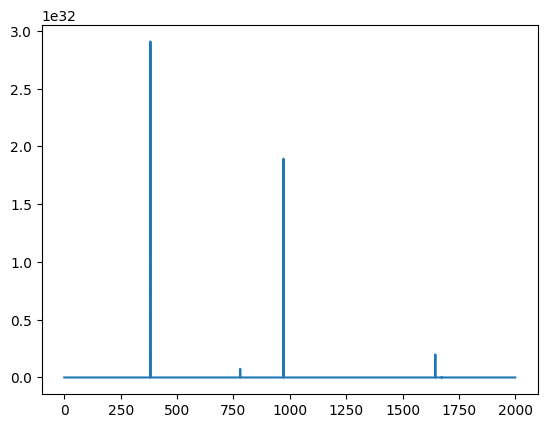

In [2]:
# Data for "global" plots
plt.plot(losses)

In [3]:
from cnpe_validation.utils import get_posterior_db_reference_posterior

reference_posterior = get_posterior_db_reference_posterior("eight_schools-eight_schools_noncentered")

(-20.0, 20.0)

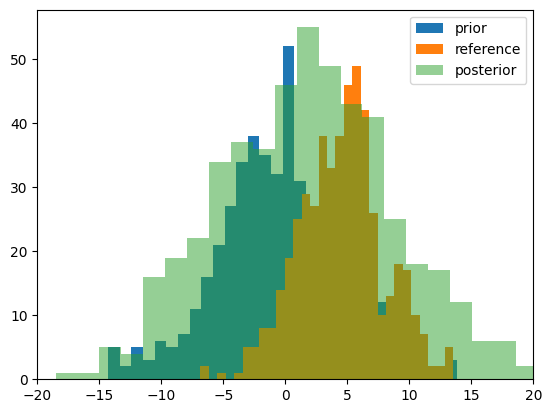

In [16]:
import jax.numpy as jnp

n_plot = 500
col = 3
var = "mu"
posterior = Predictive(guide_aml, num_samples=n_plot)(key, observations[model.obs_name])
plt.hist(Predictive(model, num_samples=n_plot)(key)[var], label="prior", bins=30)
plt.hist(reference_posterior[var][:n_plot].squeeze(), label="reference", bins=30)
plt.hist(posterior[var], label="posterior", alpha=0.5, bins=30)
plt.legend()
plt.xlim(-20, 20) 

In [9]:
jnp.log(reference_posterior["tau"]).shape

(10000, 1)